<a href="https://colab.research.google.com/github/san-11/Covid19Fake-News-detection./blob/main/Covid19_related_Fake_News_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

In [ ]:
# Basic imports
import pandas as pd
import numpy as np
import itertools

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP Libs
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import spacy

import re, unicodedata
from bs4 import BeautifulSoup

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
data=pd.read_csv('english_test_with_labels.csv')
print(data)

        id                                              tweet label
0        1  Our daily update is published. States reported...  real
1        2             Alfalfa is the only cure for COVID-19.  fake
2        3  President Trump Asked What He Would Do If He W...  fake
3        4  States reported 630 deaths. We are still seein...  real
4        5  This is the sixth time a global health emergen...  real
...    ...                                                ...   ...
2135  2136  #CoronaVirusUpdates: State-wise details of Tot...  real
2136  2137  Tonight 12(midnight) onwards Disaster Manageme...  fake
2137  2138  296 new cases of #COVID19Nigeria; Plateau-85 E...  real
2138  2139  RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...  real
2139  2140  More than half of pregnant women recently admi...  real

[2140 rows x 3 columns]


In [ ]:
data['label'].value_counts()

real    1120
fake    1020
Name: label, dtype: int64

In [ ]:
data["label"]= data["label"].str.replace("fake", "FAKE", case = False)
data["label"]= data["label"].str.replace("Fake", "FAKE", case = False)
data["label"]= data["label"].str.replace("real", "TRUE", case = False)
data['label'].value_counts()

TRUE    1120
FAKE    1020
Name: label, dtype: int64

Filling Rows with Missing Labels

In [ ]:
label_column=data['label'].isnull()
label_column

for i in range (1164):
    if(label_column[i]==True):
        print(i)

data.loc[5]['label'] = 'TRUE'
data.loc[15]['label'] = 'FAKE'
data.loc[43]['label'] = 'FAKE'
data.loc[131]['label'] = 'TRUE'
data.loc[242]['label'] = 'TRUE'

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


Filling Missing Values

In [ ]:
data.isnull().sum()

id       0
tweet    0
label    0
dtype: int64

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# 1. Cleaning html-scrapped text/unicode characters
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def clean_unicode(text):
    return unicodedata.normalize("NFKD",BeautifulSoup(text, "lxml").text)

# 2. Removing URLs
def rem_urls(text):
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'pic.twitter.com/[\w]*',"", text)
    return text

#3. Removing punctuation, special characters & numbers
def rem_punc(text):
    return re.sub('[^A-Za-z]+', ' ', text)

# 4. Making sure any double-spaces are single
def rem_dspaces(text):
    return re.sub('  ',' ', text)

# 5. Transforming all text to lowercase
def to_lower(text):
    return text.lower()

# 6. Removing stop words
stop = set(stopwords.words('english'))
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return ' '.join(final_text)

# Final function to clean everything
def clean_data(text):
    text = strip_html(text)
    text = rem_urls(text)
    text = clean_unicode(text)
    text = rem_punc(text)
    text = rem_dspaces(text)
    text = to_lower(text)
    text = remove_stopwords(text)
    return text

In [ ]:
# Applying the function on our tweet column
data["tweet"] = data["tweet"].apply(clean_data)

In [ ]:
data['tweet'][0]

'daily update published states reported k tests k new cases deaths current hospitalizations fell k first time since june httpstcowzsyme sht'

In [ ]:
data['tweet'][56]

'ncdc directly contacted twitter user mentioned friend returned uk runny nose could reach authorities testing within hours communication us via dm sample collected committed best httpstcofccdgij ug'

Data Exploration/Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


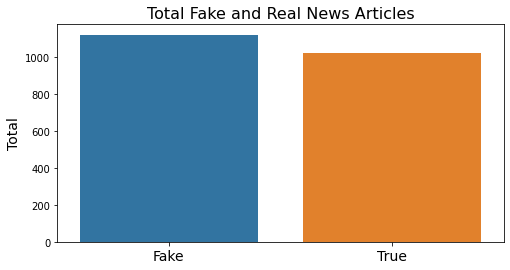

TRUE    1120
FAKE    1020
Name: label, dtype: int64


In [ ]:
# As we can see now, we are dealing a fairly balanced dataset
plt.figure(figsize=(8,4))
sns.countplot(data['label'])
plt.title('Total Fake and Real News Articles', fontsize=16)
plt.ylabel('Total', fontsize=14)
plt.xlabel('')
plt.xticks([0, 1], ['Fake', 'True'], fontsize=14)

plt.show()
print(data['label'].value_counts())

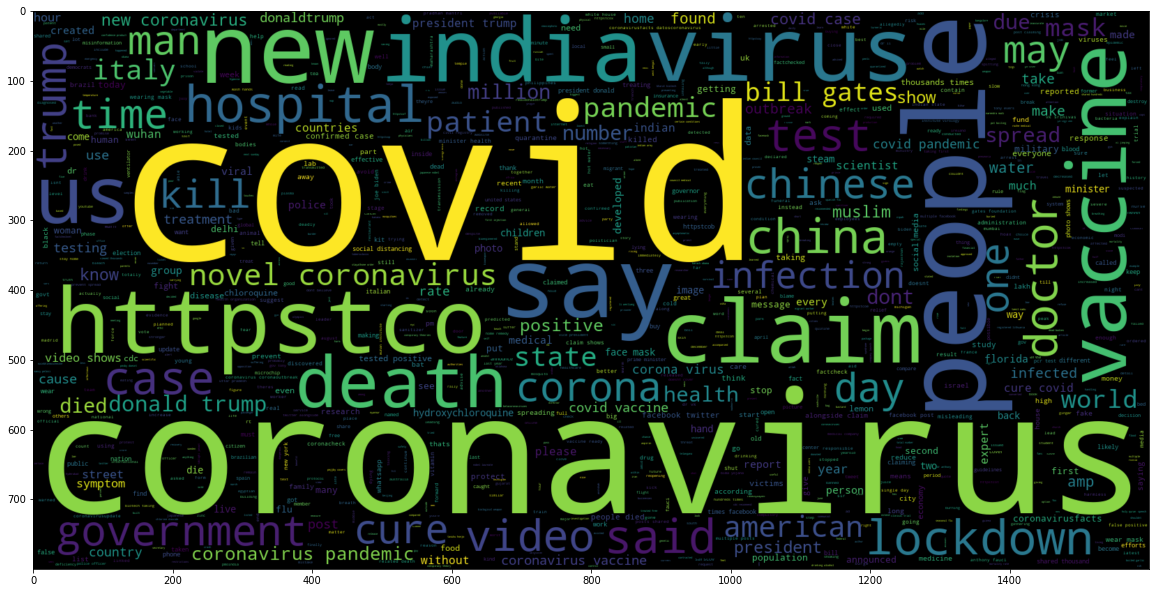

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == "FAKE"].tweet))
plt.imshow(wc, interpolation = 'bilinear')

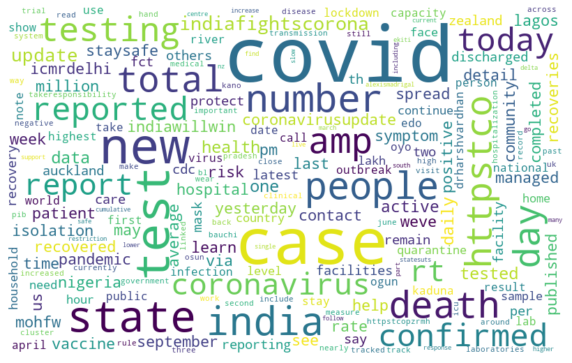

In [ ]:
# Real News
real_data = data[data['label'] == "TRUE"]
all_words = ' '.join([text for text in real_data['tweet']])

wordcloud = WordCloud(width= 800, height= 500,
                          background_color ='white',
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

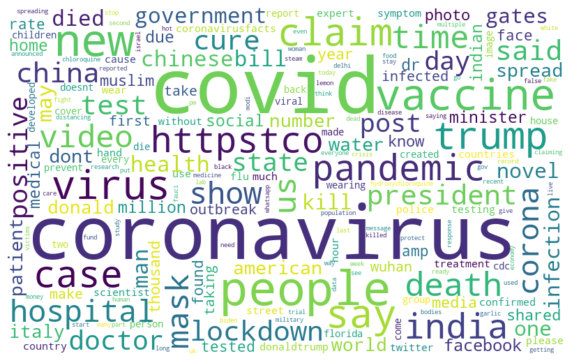

In [ ]:
# Fake News
fake_data = data[data['label'] == "FAKE"]
all_words = ' '.join([text for text in fake_data['tweet']])

wordcloud = WordCloud(width= 800, height= 500,
                          background_color ='white',
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Most Frequent Words

In [ ]:
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity, plot_color):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Frequency", y = "Word", color = plot_color)
    ax.set_xlabel('Frequency', fontsize = 14)
    ax.set_ylabel('Words', fontsize = 14)
    plt.xticks(rotation='horizontal')

    plt.show()

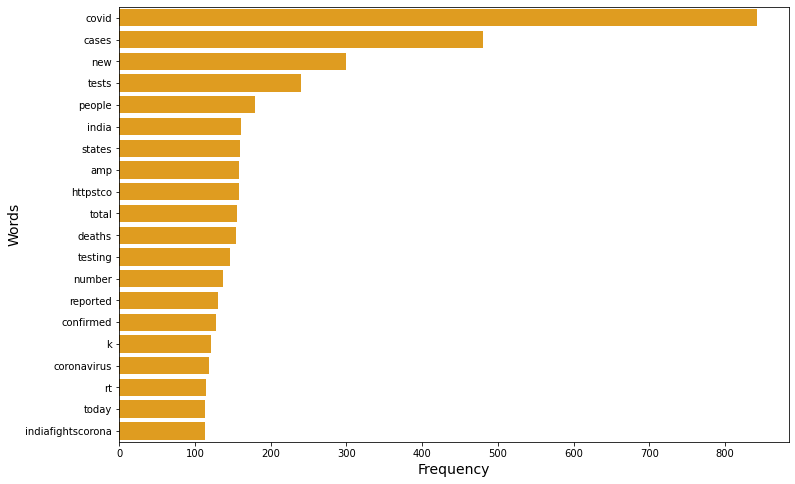

In [ ]:
# 20th Most frequent Real News words
counter(data[data['label'] == 'TRUE'], 'tweet', 20, 'Orange')

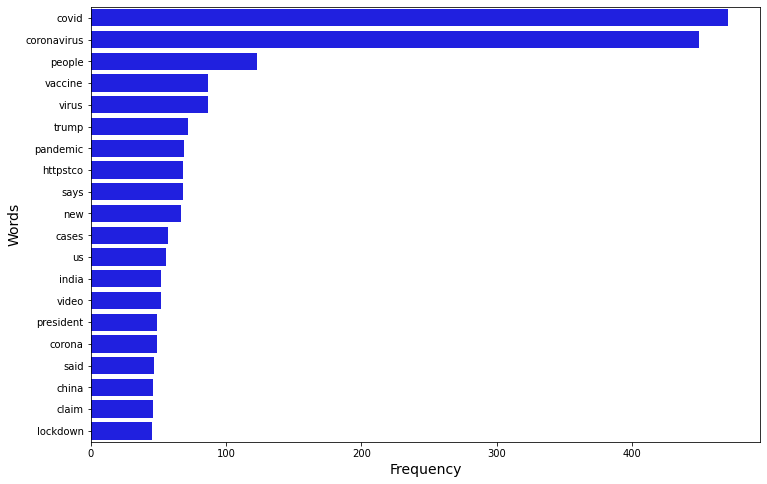

In [ ]:
# 20th Most frequent Fake News words
counter(data[data['label'] == 'FAKE'], 'tweet', 20, 'Blue')

Data Modeling

In [ ]:
# First, we need to split the data
X = data['tweet']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Now, To get a good idea if the words and tokens in the articles had a significant impact on whether (1/2)
# the news was fake or real, we begin by using Bag of Words (BOW) and Term Frequency

Count Vectorizer

---Vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which is used to find word predictions, word similarities/semantics.



In [ ]:
# Initializing the CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fitting and transforming the training data
cv_train = count_vectorizer.fit_transform(X_train)

# Transforming the test set
cv_test = count_vectorizer.transform(X_test)

TF-IDF Vectorizer

---Term frequency refers to the frequency of the word in a document. Inverse document frequency reduces the scores of the words that appear too much across all the documents.



In [ ]:
# Initializing the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fitting and transforming the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transforming the test set
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
# Getting the feature names of CountVectorizer
print(count_vectorizer.get_feature_names()[:10])

['aapolicyforum', 'ab', 'abandon', 'abc', 'abhigya', 'abia', 'abigail', 'ability', 'able', 'absence']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Getting the feature names of TfidfVectorizer
print(tfidf_vectorizer.get_feature_names()[-10:])

['ztwdor', 'zubqhqvkj', 'zuk', 'zuoc', 'zviv', 'zvxq', 'zx', 'zxrn', 'zydus', 'zytaud']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Classification

In [ ]:
# First we create a unction to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Model 1: Logistic **Regression**
---Precision is defined as the ratio of true positives to the sum of true and false positives.

---Recall is defined as the ratio of true positives to the sum of true positives and false negatives.

---F1 Score is the weighted harmonic mean of precision and recall. The closer the value of the F1 score is to 1.0, the better the expected performance of the model is.

---Support is the number of actual occurrences of the class in the dataset. It doesn’t vary between models, it just diagnoses the performance evaluation process.


In [ ]:
# Fitting the model
lreg = LogisticRegression()
lreg.fit(tfidf_train, y_train)
lreg_pred = lreg.predict(tfidf_test)
print("Accuracy Score: {}%".format(round(accuracy_score(y_test, lreg_pred)*100,2)))

Accuracy Score: 89.95%


In [ ]:
# Printing classification report
lreg_report = classification_report(y_test, lreg_pred, target_names = ['0','1'])
print(lreg_report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       204
           1       0.91      0.89      0.90       224

    accuracy                           0.90       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.90      0.90      0.90       428



Confusion matrix, without normalization


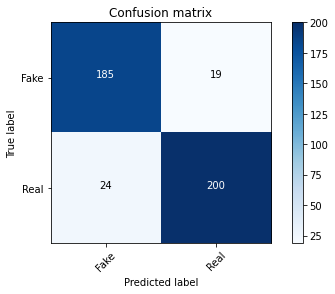

In [ ]:
# Printing Confusion Matrix
cm = confusion_matrix(y_test, lreg_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Model 2: Naive Bayes Classifier

In [ ]:
# Fitting the model
mnb = MultinomialNB()
mnb.fit(tfidf_train, y_train)
mnb_pred = mnb.predict(tfidf_test)
print("Accuracy Score: {}%".format(round(accuracy_score(y_test, mnb_pred)*100,2)))

Accuracy Score: 89.02%


In [ ]:
# Printing classification report
mnb_report = classification_report(y_test, mnb_pred, target_names = ['0','1'])
print(mnb_report)

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       204
           1       0.86      0.94      0.90       224

    accuracy                           0.89       428
   macro avg       0.90      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428



Confusion matrix, without normalization


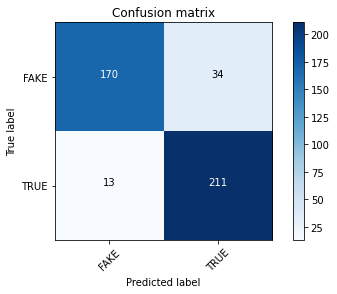

In [ ]:
# Printing Confusion Matrix
cm = confusion_matrix(y_test, mnb_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'TRUE'])

# Model 3: Decision Tree Classifier

In [ ]:
# Fitting the model
dt = DecisionTreeClassifier()
dt.fit(tfidf_train, y_train)
dt_pred = dt.predict(tfidf_test)
print("Accuracy Score: {}%".format(round(accuracy_score(y_test, dt_pred)*100,2)))

Accuracy Score: 82.01%


In [ ]:
# Printing classification report
dt_report = classification_report(y_test, dt_pred, target_names = ['0','1'])
print(dt_report)

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       204
           1       0.84      0.81      0.83       224

    accuracy                           0.82       428
   macro avg       0.82      0.82      0.82       428
weighted avg       0.82      0.82      0.82       428



Confusion matrix, without normalization


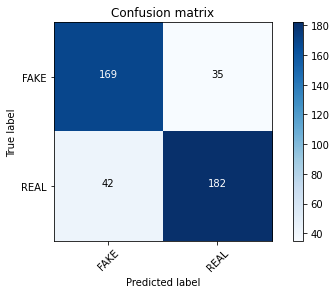

In [ ]:
# Printing Confusion Matrix
cm = confusion_matrix(y_test, dt_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])


## Support Vector Machine

In [ ]:
# Fitting the model
support_vector_machine=svm.SVC(kernel='linear')
support_vector_machine.fit(tfidf_train, y_train)
svm_pred = support_vector_machine.predict(tfidf_test)
print("Accuracy Score: {}%".format(round(accuracy_score(y_test, svm_pred)*100,2)))

Accuracy Score: 92.06%


In [ ]:
# Printing classification report
svm_report = classification_report(y_test, svm_pred, target_names = ['0','1'])
print(svm_report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       204
           1       0.93      0.92      0.92       224

    accuracy                           0.92       428
   macro avg       0.92      0.92      0.92       428
weighted avg       0.92      0.92      0.92       428



Confusion matrix, without normalization


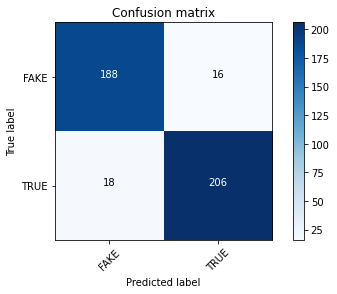

In [ ]:
# Printing Confusion Matrix
cm = confusion_matrix(y_test, svm_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'TRUE'])

## The support vector machine performed the best here and gave an accuracy of 92.06%

In [ ]:
support_vector_machine.fit(tfidf_train, y_train)

SVC(kernel='linear')

Train-Test Split

In [ ]:
y=data.label
y

0       TRUE
1       FAKE
2       FAKE
3       TRUE
4       TRUE
        ... 
2135    TRUE
2136    FAKE
2137    TRUE
2138    TRUE
2139    TRUE
Name: label, Length: 2140, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], y, test_size=0.2,random_state=102)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1712,) (1712,)
(428,) (428,)


In [ ]:
data.drop("label", axis=1,inplace=True)

Pipeline Creation

---assembles several steps that can be cross validated together while setting diff paarmeters



In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.80)),
    ('clf',svm.SVC(kernel='linear'))])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.8, stop_words='english')),
                ('clf', SVC(kernel='linear'))])

In [ ]:
result=pipeline.predict([" a conspiracy theory suggests China is benefiting from the pandemic;"])
print(result)

['FAKE']


In [ ]:
result=pipeline.predict(["#IndiaFightsCorona Following the national trend 17 States"])
print(result)

['TRUE']
